In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input
import matplotlib.pyplot as plt

In [2]:
# path to data
train_dir = 'dataset/train'
val_dir = 'dataset/valid'
test_dir = 'dataset/test'

img_size = 224
batch_size = 32

In [3]:
# enhanced training data by ...
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
# read data from directory
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


In [5]:
# 创建 ConvNeXt 基础模型，这里设置 include_top=False，因为我们将添加自定义的全连接层
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# input_shape = base_model.input_shape
# print("ConvNeXt 输入尺寸:", input_shape)

# 冻结基础模型的参数，以便在训练初期不对其进行更新
base_model.trainable = False

# 然后你可以构建你的模型
input_layer = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)
model = tf.keras.Model(input_layer, output_layer)

In [6]:
# 编译模型
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
epochs = 10  # 根据需要调整
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/10


/Users/xingruizhu/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712550249.402085 5950638 service.cc:145] XLA service 0x317ee74e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712550249.402427 5950638 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1712550249.510406 5950638 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 791s 8s/step - accuracy: 0.0747 - loss: 3.0969 - val_accuracy: 0.3300 - val_loss: 2.7170
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 807s 8s/step - accuracy: 0.3166 - loss: 2.4546 - val_accuracy: 0.6400 - val_loss: 1.9897
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 800s 8s/step - accuracy: 0.6118 - loss: 1.9598 - val_accuracy: 0.7700 - val_loss: 1.3899
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 794s 8s/step - accuracy: 0.7361 - loss: 1.5812 - val_accuracy: 0.8300 - val_loss: 1.0192
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 799s 8s/step - accuracy: 0.8115 - loss: 1.3222 - val_accuracy: 0.9200 - val_loss: 0.7948
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 804s 8s/step - accuracy: 0.8499 - loss: 1.1169 - val_accuracy: 0.9500 - val_loss: 0.7386
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 813s 8s/step - accuracy: 0.8791 - loss: 0.9588 - val_accuracy: 0.9700 - val_loss: 0.5525
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 811s 8s/step - accuracy: 0.8967 - loss: 0.8541 - val_accuracy: 0.970

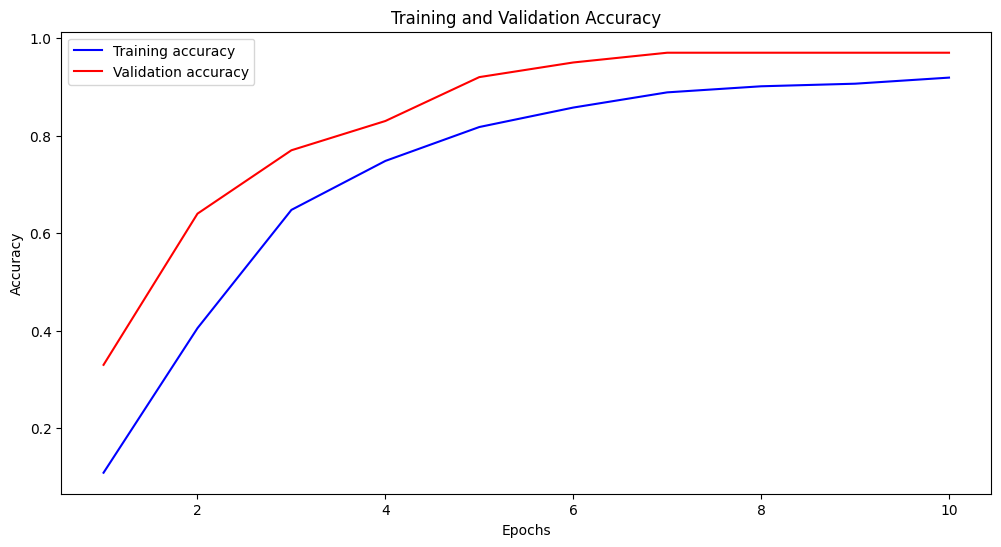

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.9633 - loss: 0.3527
Test Accuracy: 0.949999988079071


In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

model.save('model.keras')
# 评估模型
